# Analysis of AP systems


In [ ]:
# Walter Fontana 2020-2023

Preambles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#%matplotlib widget
import matplotlib as mpl
import matplotlib.backends.backend_pdf

In [3]:
#mpl.rcParams['figure.figsize'] = [8, 6]
#mpl.rcParams['figure.dpi'] = 300 #72

In [4]:
#
import kainit
import kamix
import kalarm
import kamol
import kaparam
import kareact
import kasig
import kasim
import kasystem
import kaheap
import kamatch
import kaviz
import kasnap
import kagraph
import kaplot

In [5]:
#import commands as cmd

import networkx as nx
import pandas as pd
import numpy as np
from math import ceil

import seaborn as sns

import matplotlib.pyplot as plt
import os
import bz2
import pickle
import sys
import re

In [6]:
import warnings
warnings.filterwarnings(action='once')

In [7]:
warnings.filterwarnings('ignore')

#### Define directories

In [8]:
root = '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/'
path, directories, files = next(os.walk(root))
dir_list = [os.path.join(path, d) for d in directories if re.match(r'.*_A100_P100_[0-9]$', d)]

In [9]:
dir_list.sort()
dir_list

['/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/T25_A100_P100_0',
 '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/T25_A100_P100_1',
 '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/T25_A100_P100_2',
 '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/T25_A100_P100_3',
 '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/T25_A100_P100_4']

#### Simulation progress check

In [ ]:
root = '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/'
snapshot_directory = root + 'T25_A100_P100_1/'
csv_directory = snapshot_directory
csv_datafile = csv_directory + 'output_T25.csv'
results_directory = 'PDanalysis/'

In [ ]:
print(f'snapshot_directory = {snapshot_directory}')
print(f'csv_directory = {csv_directory}')
print(f'csv_datafile = {csv_datafile}')
print(f'results_directory = {results_directory}')

In [ ]:
data = pd.read_csv(csv_datafile, comment='#')
data.fillna(0, inplace=True)

In [ ]:
if 'pX' in locals():
    plt.close(pX.fig)
pX = kaplot.XY_plot(params={'linestyle': '-', 'linewidth': 1, 'markersize': 2})
pX.ax.set_xscale('linear')
pX.ax.set_yscale('log')
pX.add(data, x='time', y='sz-rank 1', params={'label': 'max', 'color': 'r'})
pX.ax.legend();

#### Pattern stats in a snapshot

In [ ]:
def patterns(snapshot, pattern_list, local_views=False):

    # get a site graph matcher
    SGM = kamatch.SiteGraphMatcher()

    # turn the patterns into internal representations
    ip = [kamol.KappaComplex(p, canon=False) for p in pattern_list]

    # read the snapshot
    print(f' scanning {snapshot}', end='\r')
    snap = kasnap.SnapShot(snapshot)
    print(f'analyzing {snapshot}', end='\r')

    if local_views:
        all_lv = list(snap.local_views.keys())
    else:
        all_lv = []
    columns = ['complex', 'size', 'count', 'composition'] + all_lv + pattern_list
    df = pd.DataFrame(columns=columns)
    data = []

    # sort complexes with decreasing size
    snap.complexes.sort(key=lambda m: m.size, reverse=True)

    idx = 1
    for c in snap.complexes:
        # distinguishable embeddings in c modulo automorphisms
        pattern_count = []
        local = []
        for p in ip:
            pattern_count.append(SGM.number_of_all_embeddings(c, p) / len(SGM.automorphisms(p)))
        if local_views:
            for lv in all_lv:
                if lv in c.local_views:
                    local.append(len(c.local_views[lv]))
                else:
                    local.append(0)
        data.append([idx, c.size, c.count, c.composition] + local + pattern_count)
        idx += 1

    # fill the dataframe

    df = df.append(pd.DataFrame(data, columns=columns))
    print(f'done {" ":100}')
    return df

In [ ]:
pattern_list_1 = ['A(p[.])', 
                  'A(l[.])', 
                  'A(r[.])', 
                  'A(l[.] r[.])', 
                  'P(d[.])', 
                  'P(a1[.])', 
                  'P(a2[.])',
                  'P(a3[.])', 
                  'A(r[1]), A(l[1])', 
                  'A(p[1]), P(a1[1])', 
                  'A(p[1]), P(a2[1])', 
                  'A(p[1]), P(a3[1])', 
                  'P(d[1]), P(d[1])']

In [ ]:
pattern_list_2 = ['A(p[.])', 
                  'A(l[.])', 
                  'A(l[.] r[.])', 
                  'A(r[1]), A(l[1])', 
                  'P(d[1]), P(d[1])']

Note: |A| = |A(l[.])| + |A(r[1]), A(l[1])|

Why?

|A(r[1]), A(l[1])| is the number of AA bonds. |A(l[.])| is the number of connected components containing AA chains. The number bonded As in a component equals the number of AA bonds + 1. Thus, for each component of AA chains, |A(l[.])| + |A(r[1]), A(l[1])| is the number of As. Summing up over all components yields the total number of As.

In [ ]:
pattern_list = pattern_list_2
df0 = patterns(root + 'T25_A100_P100_0/' + 'snap_T25_0066.ka', pattern_list)
df0.set_index('complex', inplace=True)
df1 = patterns(root + 'T25_A100_P100_1/' + 'snap_T25__end.ka', pattern_list)
df1.set_index('complex', inplace=True)
df2 = patterns(root + 'T25_A100_P100_2/' + 'snap_P_C100__end.ka', pattern_list)
df2.set_index('complex', inplace=True)
df3 = patterns(root + 'T25_A100_P100_3/' + 'snap_A_C100__end.ka', pattern_list)
df3.set_index('complex', inplace=True)
df4 = patterns(root + 'T25_A100_P100_4/' + 'snap033.ka', pattern_list)
df4.set_index('complex', inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df0

#### structure rendering

In [10]:
def layout_graphs(snapshot_list, index_list, layout="circo"):
    renderers = []
    for snapshot in snapshot_list:
        snap = kasnap.SnapShot(snapshot, sort=True)
        for i in index_list:
            print(f'{snapshot:20s} / {i:5d}', end='\r')  # progress
            size = snap.complexes[i].size
            n_bonds = len(snap.complexes[i].bonds)
            file_id = snapshot.split("snap")[1].split(".ka")[0]
            A_agents = 0
            P_agents = 0
            APratio = 'na'
            if 'A' in snap.complexes[i].composition:
                A_agents = snap.complexes[i].composition['A']
            if 'P' in snap.complexes[i].composition:
                P_agents = snap.complexes[i].composition['P']
            if P_agents != 0:
                APratio = f'{A_agents / P_agents:.3f}'
            title = f"{file_id}/{i}/t={snap.time:.3f} {size}/{n_bonds} A/P={APratio}"
            r = kaviz.Renderer(snap.complexes[i], prog=layout)
            renderers.append((r, title))
    print("Done")
    return renderers

In [11]:
def display_graphs(renderers, rows=4, cols=4, canvas_size=(10, 10), 
                   node_size=2, 
                   labels='no', 
                   line_width=0.3, 
                   legend=False, 
                   edge_color='black', 
                   title_font_size=8):
    canvas = []
    canvas.append(kaviz.Canvas(rows, cols, canvas_size))
    board = canvas[len(canvas)-1]  # current graphics board
    n = 1
    for r, title in renderers:        
        # check if we need a new board
        if n > rows * cols:
            canvas.append(kaviz.Canvas(rows, cols, canvas_size))
            board = canvas[len(canvas)-1]
            n = 1
        r.render(board, board.index2panel(n), node_size=node_size, labels=labels, line_width=line_width, 
                 legend=legend, edge_color=edge_color, title=title, title_font_size=title_font_size)
        n += 1
    return canvas

In [12]:
def canvas2pdf(canvas_list, outfile):
    pdf = matplotlib.backends.backend_pdf.PdfPages(outfile)
    for c in canvas_list:
        pdf.savefig(c.figure)
    pdf.close()

In [13]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [14]:
root = '/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/'
snapshot_directory = root + 'T25_A100_P100_4/'
results_directory = ' Notes/'

In [ ]:
start = 10
end = 20
padding = 3
snapshot_list = []
for i in range(start, end+1):        
    file = snapshot_directory + 'snap' + f'{i:0{padding}d}' + '.ka'
    snapshot_list.append(file)
for sl in snapshot_list:
    print(sl)

In [ ]:
index_list = [0] # maximer

In [ ]:
renderers = layout_graphs(snapshot_list, index_list, layout="circo")

In [ ]:
%%capture
canvas = display_graphs(renderers, node_size=10, canvas_size=(15, 15), title_font_size=10)

In [ ]:
from IPython import display

In [ ]:
# interactive display (number to proceed to the corresponding canvas; q to quit)
i = 0
while True:
    print(f"canvas {i+1}/{len(canvas)}")
    print(f'# of canvas; q to quit; enter to increment', end = '\r')
    display.clear_output(wait=True)
    display.display(canvas[i].figure)
    k = input()
    if k == 'q':
        break
    elif is_number(k):
        if int(k) > len(canvas):
            i = 0
        else:
            i = int(k) - 1
    else:
        i = (i + 1) % len(canvas)

In [ ]:
canvas2pdf(canvas, 'circo.pdf')

**using Renderer and render()**

In [15]:
snapshot_directory

'/Users/wf7/Desktop/-CombiFluids/SiteSim/PhaseDiagram/T25_A100_P100_4/'

In [20]:
snap = kasnap.SnapShot(snapshot_directory + "snap025.ka", sort=True)

In [21]:
print(f"{snap.complexes[0].size}.{len(snap.complexes[0].bonds)} at t={snap.time:.4f}")

898.1258 at t=0.2500


In [22]:
r = kaviz.Renderer(snap.complexes[0], prog='neato')

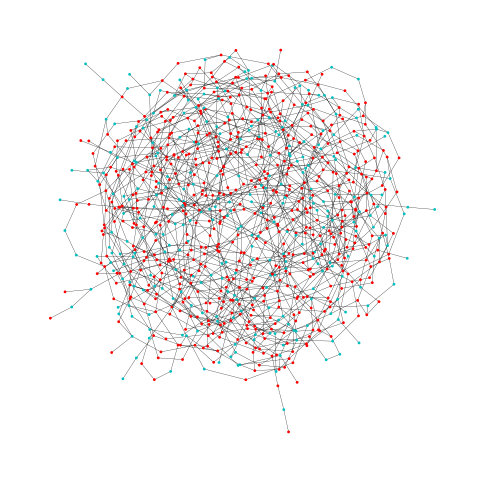

In [25]:
r.render(node_size=1, labels='no', line_width=0.2, edge_color='black', legend=False, figure_size=(6,6))

using Canvas explicitly

In [ ]:
%%capture
canvas = kaviz.Canvas(4,4)

In [ ]:
r.render(canvas, (1,1), node_size=10, labels='no', line_width=0.2, legend=False, figure_size=(4,4))

In [ ]:
canvas.figure

In [ ]:
del canvas

**sub-embeddings**

In [ ]:
SGM = kamatch.SiteGraphMatcher()

In [ ]:
SGM.sub_embed(snap.complexes[0], snap2.complexes[44])

In [ ]:
len(SGM.mapping)

In [ ]:
r.graph.write_dot(filename='t0_1.dot', shape='circle')